In [ ]:
! pip install dicom2jpg pydicom imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter

import tensorflow as tf
from skimage.util import img_as_ubyte
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, GlobalAveragePooling2D, concatenate, \
    DepthwiseConv2D, Concatenate
from keras.layers import Input, Add, BatchNormalization, AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam , Adamax
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
tf.compat.v1.enable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pydicom
from skimage import exposure, io
from PIL import Image
import imageio

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def convert_dicom_to_png(dicom_path):
    try:
        ds = pydicom.dcmread(dicom_path)
        image = ds.pixel_array
        image = exposure.equalize_adapthist(image)
        image = img_as_ubyte(image)

        output_png_path = dicom_path[:-4] + '.png'
        io.imsave(output_png_path, image, check_contrast=False)
        os.remove(dicom_path)
    except Exception as e:
        print(f"Error processing {dicom_path}: {str(e)}")

classify = []
path = []

In [ ]:
SEARCH_PATH = "drive/MyDrive/Dataset"

all_files = []
matches = []
# matches = ["Kidney Cancer", "Bengin"]

for root, dirs, files in os.walk(SEARCH_PATH):
    if not any(x in root for x in matches):
      for file in files:
          if file.endswith(tuple(['dcm', 'png', 'jpg', 'jpeg', 'tif'])):
              relativePath = os.path.relpath(root, SEARCH_PATH)
              if relativePath == ".":
                  relativePath = ""
              all_files.append(
                  (relativePath.count(os.path.sep),
                  relativePath,
                  file
                  )
              )

all_files.sort(reverse=True)

index = 0
for (count, folder), files in groupby(all_files, itemgetter(0, 1)):
    index = index + 1
    for file in files:
        file_path = "drive/MyDrive/Dataset" + "/" + folder + "/" + file[2]
        if file[2].endswith('.dcm'):
            convert_dicom_to_png(file_path)
            file_path = file_path + '.png'
        classify.append(' '.join(folder.split("/")[0].split(' ')[:-1]))
        path.append(file_path)

print("Total Directories Visited: ", index)

Total Directories Visited:  230


In [ ]:
df = pd.DataFrame(list(zip(path, classify)), columns=['path', 'class'])
df.head()

path    class
0  drive/MyDrive/Dataset/Bladder Cancer/manifest-...  Bladder
1  drive/MyDrive/Dataset/Bladder Cancer/manifest-...  Bladder
2  drive/MyDrive/Dataset/Bladder Cancer/manifest-...  Bladder
3  drive/MyDrive/Dataset/Bladder Cancer/manifest-...  Bladder
4  drive/MyDrive/Dataset/Bladder Cancer/manifest-...  Bladder

In [ ]:
for category in list(df['class'].unique()):
  print(category, df[df['class'] == category].shape)

Bladder (207, 2)
Prostate (169, 2)
Thyroid (62, 2)
Lung (11247, 2)
Colon (8969, 2)
Mantle Cell Lymphoma (122, 2)
Follicular Lymphoma (139, 2)
Chronic Lymphocytic Leukemia (113, 2)
Bengin (120, 2)


In [ ]:
df.shape

(21148, 2)

In [ ]:
df['class'].unique()

array(['Bladder', 'Prostate', 'Thyroid', 'Lung', 'Colon',
       'Mantle Cell Lymphoma', 'Follicular Lymphoma',
       'Chronic Lymphocytic Leukemia', 'Bengin'], dtype=object)

In [ ]:
X = df['path']
y = df['class']

In [ ]:
X

0        drive/MyDrive/Dataset/Bladder Cancer/manifest-...
1        drive/MyDrive/Dataset/Bladder Cancer/manifest-...
2        drive/MyDrive/Dataset/Bladder Cancer/manifest-...
3        drive/MyDrive/Dataset/Bladder Cancer/manifest-...
4        drive/MyDrive/Dataset/Bladder Cancer/manifest-...
                               ...                        
21143    drive/MyDrive/Dataset/Bengin Cancer/all_benign...
21144    drive/MyDrive/Dataset/Bengin Cancer/all_benign...
21145    drive/MyDrive/Dataset/Bengin Cancer/all_benign...
21146    drive/MyDrive/Dataset/Bengin Cancer/all_benign...
21147    drive/MyDrive/Dataset/Bengin Cancer/all_benign...
Name: path, Length: 21148, dtype: object

In [ ]:
y

0        Bladder
1        Bladder
2        Bladder
3        Bladder
4        Bladder
          ...   
21143     Bengin
21144     Bengin
21145     Bengin
21146     Bengin
21147     Bengin
Name: class, Length: 21148, dtype: object

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_idx, val_test_idx in splitter.split(X, y):
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]

    X_val_test = [X[i] for i in val_test_idx]
    y_val_test = [y[i] for i in val_test_idx]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for val_idx, test_idx in splitter.split(X_val_test, y_val_test):
    X_val = [X_val_test[i] for i in val_idx]
    y_val = [y_val_test[i] for i in val_idx]

    X_test = [X_val_test[i] for i in test_idx]
    y_test = [y_val_test[i] for i in test_idx]

In [ ]:
train = pd.DataFrame(list(zip(X_train, y_train)), columns=['path', 'class'])
valid = pd.DataFrame(list(zip(X_val, y_val)), columns=['path', 'class'])
test = pd.DataFrame(list(zip(X_test, y_test)), columns=['path', 'class'])

In [ ]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [ ]:
img_size = (224 , 224)

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'path' , y_col = 'class' ,target_size = img_size ,
                                       class_mode= 'categorical',color_mode = 'rgb' , shuffle= True , batch_size= 64)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'path' , y_col = 'class' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = True , batch_size= 64)
test_gen = ts_gen.flow_from_dataframe(test , x_col = 'path' , y_col = 'class' , target_size = img_size ,
                                     class_mode = 'categorical' , color_mode = 'rgb' , shuffle= False , batch_size = 64)

Found 16918 validated image filenames belonging to 9 classes.
Found 2115 validated image filenames belonging to 9 classes.
Found 2115 validated image filenames belonging to 9 classes.


In [ ]:
train_gen.class_indices

{'Bengin': 0,
 'Bladder': 1,
 'Chronic Lymphocytic Leukemia': 2,
 'Colon': 3,
 'Follicular Lymphoma': 4,
 'Lung': 5,
 'Mantle Cell Lymphoma': 6,
 'Prostate': 7,
 'Thyroid': 8}

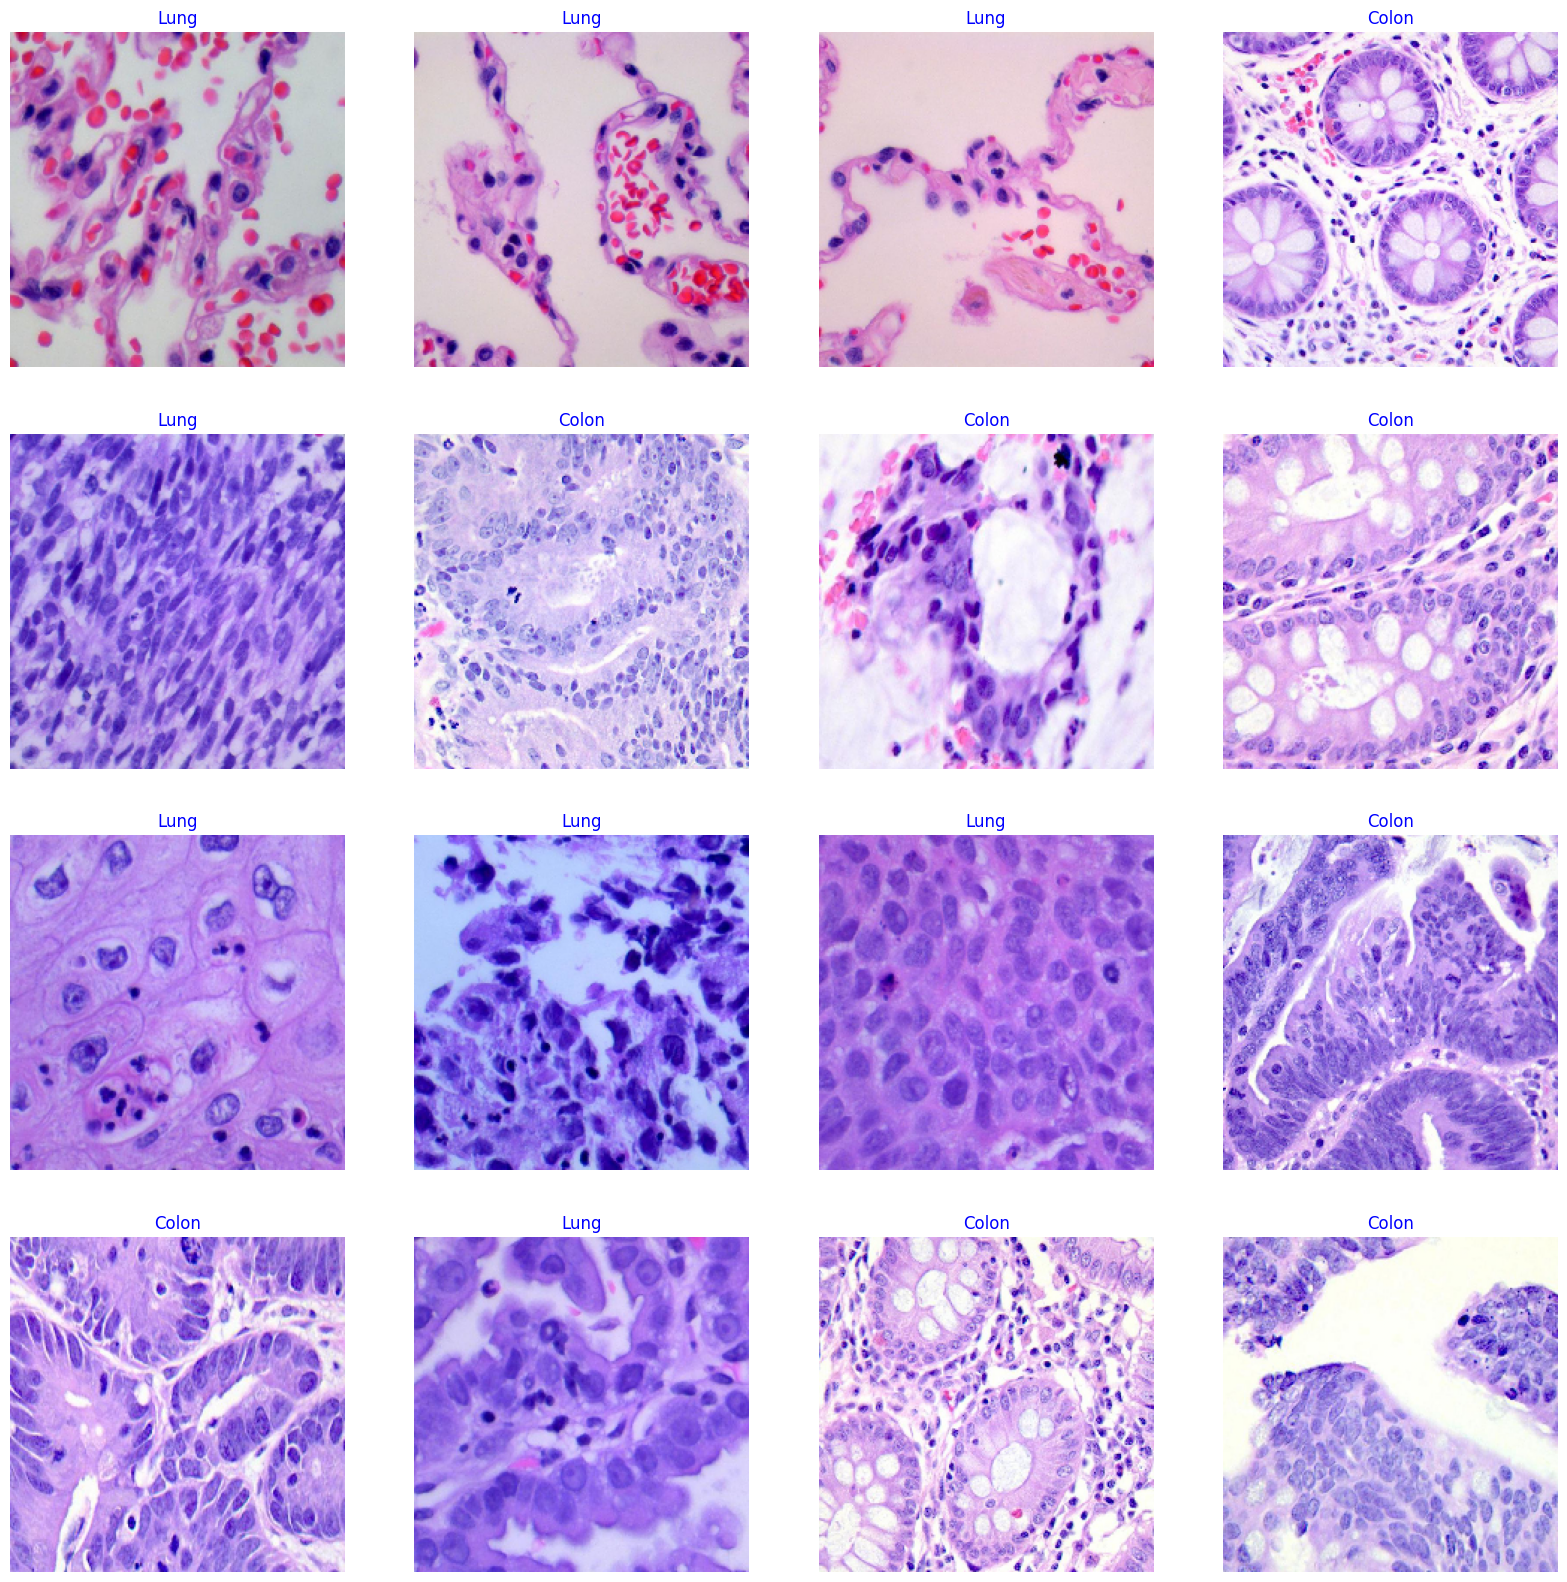

In [ ]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color= 'blue' , fontsize = 12)
    plt.axis('off')

plt.show()

In [ ]:
# model = Sequential([
#     Conv2D(filters = 64 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu',input_shape = (img_size[0] , img_size[1] , 3)),
#     Conv2D(filters = 64 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
#     MaxPooling2D(pool_size = (2,2) , strides= 2),

#     Conv2D(filters = 128 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
#     Conv2D(filters = 128 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
#     MaxPooling2D(pool_size = (2,2) , strides= 2),

#     Conv2D(filters = 256 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
#     Conv2D(filters = 256 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
#     MaxPooling2D(pool_size = (2,2) , strides= 2),

#     Conv2D(filters = 512 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
#     Conv2D(filters = 512 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
#     MaxPooling2D(pool_size = (2,2) , strides= 2),

#     Conv2D(filters = 512 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
#     Conv2D(filters = 512 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
#     MaxPooling2D(pool_size = (2,2) , strides= 2),

#     Flatten(),
#     Dense(256 , activation= 'relu'),
#     Dense(64 , activation= 'relu'),
#     Dense(len(train_gen.class_indices) , activation= 'softmax')

# ])

# model.compile(Adam(learning_rate= 0.0001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
# batch_size = 64

# total_train_batches = train_gen.samples//batch_size
# total_val_batches = valid_gen.samples//batch_size

In [ ]:
# epochs = 10

# history = model.fit(
#     x = train_gen ,
#     epochs= epochs ,
#     steps_per_epoch=total_train_batches//10,
#     validation_steps=total_val_batches//10,
#     shuffle = False,
#     verbose= 1
# )

In [ ]:
# # Define needed variables
# tr_acc = history.history['accuracy']
# tr_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]
# index_acc = np.argmax(val_acc)
# acc_highest = val_acc[index_acc]
# Epochs = [i+1 for i in range(len(tr_acc))]
# loss_label = f'best epoch= {str(index_loss + 1)}'
# acc_label = f'best epoch= {str(index_acc + 1)}'

# # Plot training history
# plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout
# plt.show()

In [ ]:
# Inception / GoogleNet
def inception_module(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_output = concatenate([conv1x1, conv3x3, conv5x5, maxpool_proj], axis=-1)
    return inception_output

input_shape = (299, 299, 3)
input_layer = Input(shape=input_shape)

x = Conv2D(64, (7, 7), padding='same', activation='relu', strides=(2, 2))(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

num_modules = 3
for _ in range(num_modules):
    x = inception_module(x, [64, 128, 128, 32, 32, 32])

x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

for _ in range(num_modules):
    x = inception_module(x, [192, 192, 192, 48, 64, 64])

x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output_layer = Dense(len(train_gen.class_indices), activation='softmax')(x)

inception_model = Model(inputs=input_layer, outputs=output_layer)

inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 64

total_train_batches = train_gen.samples//batch_size
total_val_batches = valid_gen.samples//batch_size

In [ ]:
epochs = 10

history = inception_model.fit(
    x = train_gen ,
    epochs= epochs ,
    validation_data= valid_gen,
    steps_per_epoch=total_train_batches//10,
    validation_steps=total_val_batches//10,
    shuffle = False,
    verbose= 1
)

Epoch 1/10
26/26 [==============================] - 1364s 52s/step - loss: 2.2293 - accuracy: 0.5138 - val_loss: 0.9147 - val_accuracy: 0.4062
Epoch 2/10
26/26 [==============================] - 1327s 50s/step - loss: 0.7813 - accuracy: 0.6334 - val_loss: 1.0146 - val_accuracy: 0.4740
Epoch 3/10
26/26 [==============================] - 1305s 49s/step - loss: 0.6678 - accuracy: 0.7097 - val_loss: 0.4162 - val_accuracy: 0.8177
Epoch 4/10
26/26 [==============================] - 1316s 50s/step - loss: 0.4552 - accuracy: 0.8606 - val_loss: 0.6031 - val_accuracy: 0.7708
Epoch 5/10
26/26 [==============================] - 1287s 48s/step - loss: 0.4171 - accuracy: 0.8624 - val_loss: 0.2713 - val_accuracy: 0.9115
Epoch 6/10
26/26 [==============================] - 1243s 47s/step - loss: 0.3017 - accuracy: 0.8966 - val_loss: 0.4408 - val_accuracy: 0.8229
Epoch 7/10
26/26 [==============================] - 1238s 46s/step - loss: 0.2759 - accuracy: 0.9075 - val_loss: 0.3141 - val_accuracy: 0.8698

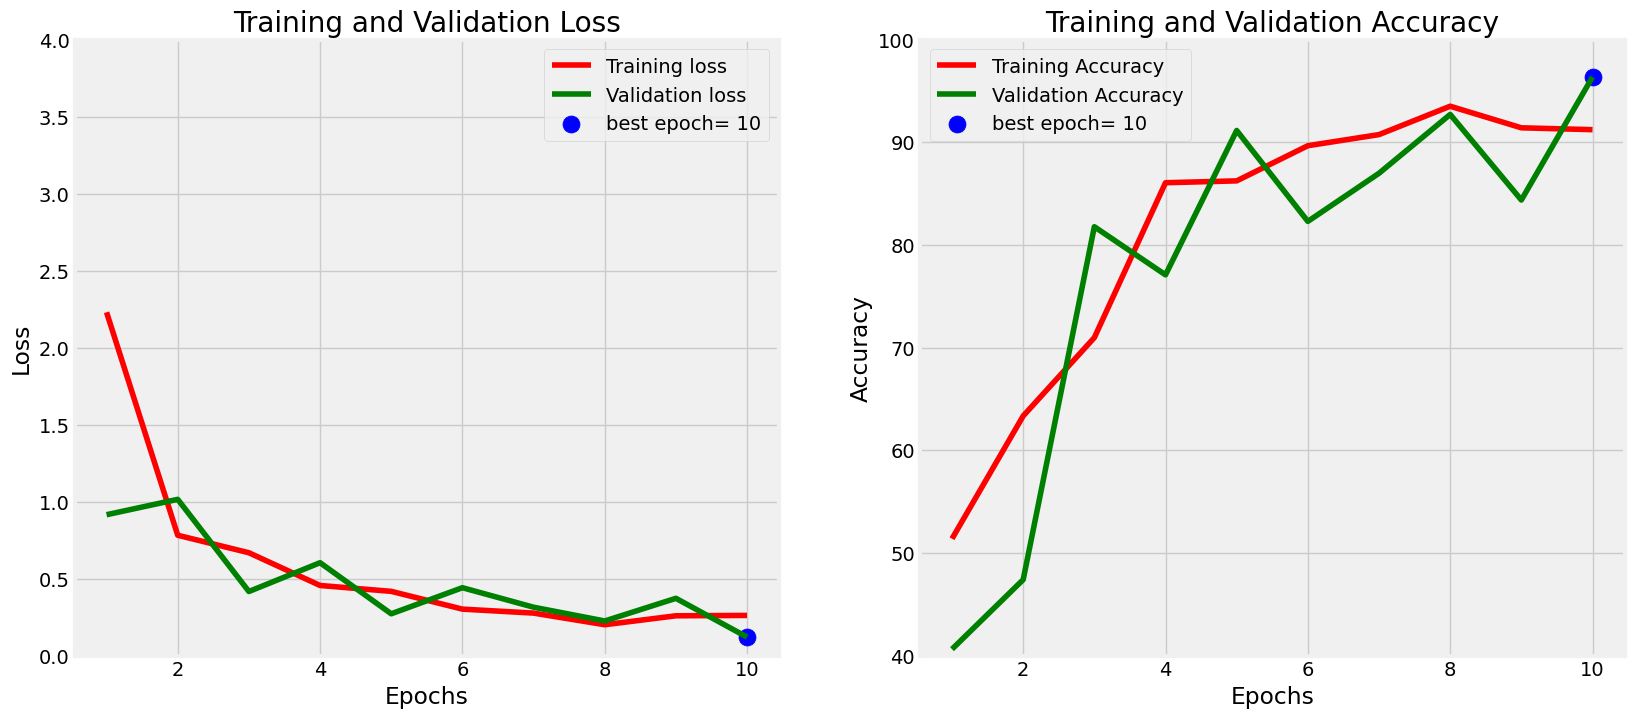

In [ ]:
# Define needed variables
tr_acc = [acc * 100 for acc in history.history['accuracy']]
tr_loss = history.history['loss']
val_acc = [acc * 100 for acc in history.history['val_accuracy']]
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.ylim(0, 4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.ylim(40, 100)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

34/34 [==============================] - 733s 22s/step


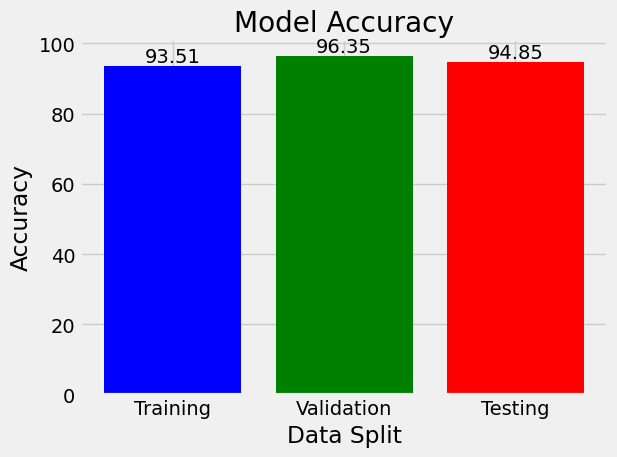

In [ ]:
test_steps = len(test_gen)
predictions = inception_model.predict(test_gen, steps=test_steps)

# Get true labels from the test data generator (assuming it's a generator with labels)
true_labels = test_gen.classes

# Calculate accuracy
accuracy = np.mean(np.argmax(predictions, axis=1) == true_labels) * 100

# Accuracy values
train_accuracy = max(tr_acc)
validation_accuracy = max(val_acc)
test_accuracy = accuracy

labels = ['Training', 'Validation', 'Testing']

accuracy_values = [train_accuracy, validation_accuracy, test_accuracy]

# Bar positions
x = range(len(labels))

plt.bar(x, accuracy_values, color=['blue', 'green', 'red'])

plt.title('Model Accuracy')
plt.xlabel('Data Split')
plt.ylabel('Accuracy')

for i, value in enumerate(accuracy_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.xticks(x, labels)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, r2_score

# Precision, Recall, F1 Score
precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
r2 = r2_score(true_labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("R2 Score:", r2)

Precision: 0.9220730273876429
Recall: 0.9484633569739953
F1 Score: 0.9336637567554635
R2 Score: 0.5323169365395728


In [ ]:
train_gen.class_indices

{'Bengin': 0,
 'Bladder': 1,
 'Chronic Lymphocytic Leukemia': 2,
 'Colon': 3,
 'Follicular Lymphoma': 4,
 'Lung': 5,
 'Mantle Cell Lymphoma': 6,
 'Prostate': 7,
 'Thyroid': 8}

In [ ]:
classes_combinations = []
class_list = list(df['class'].unique())

for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

In [ ]:
import random

random.shuffle(classes_combinations)

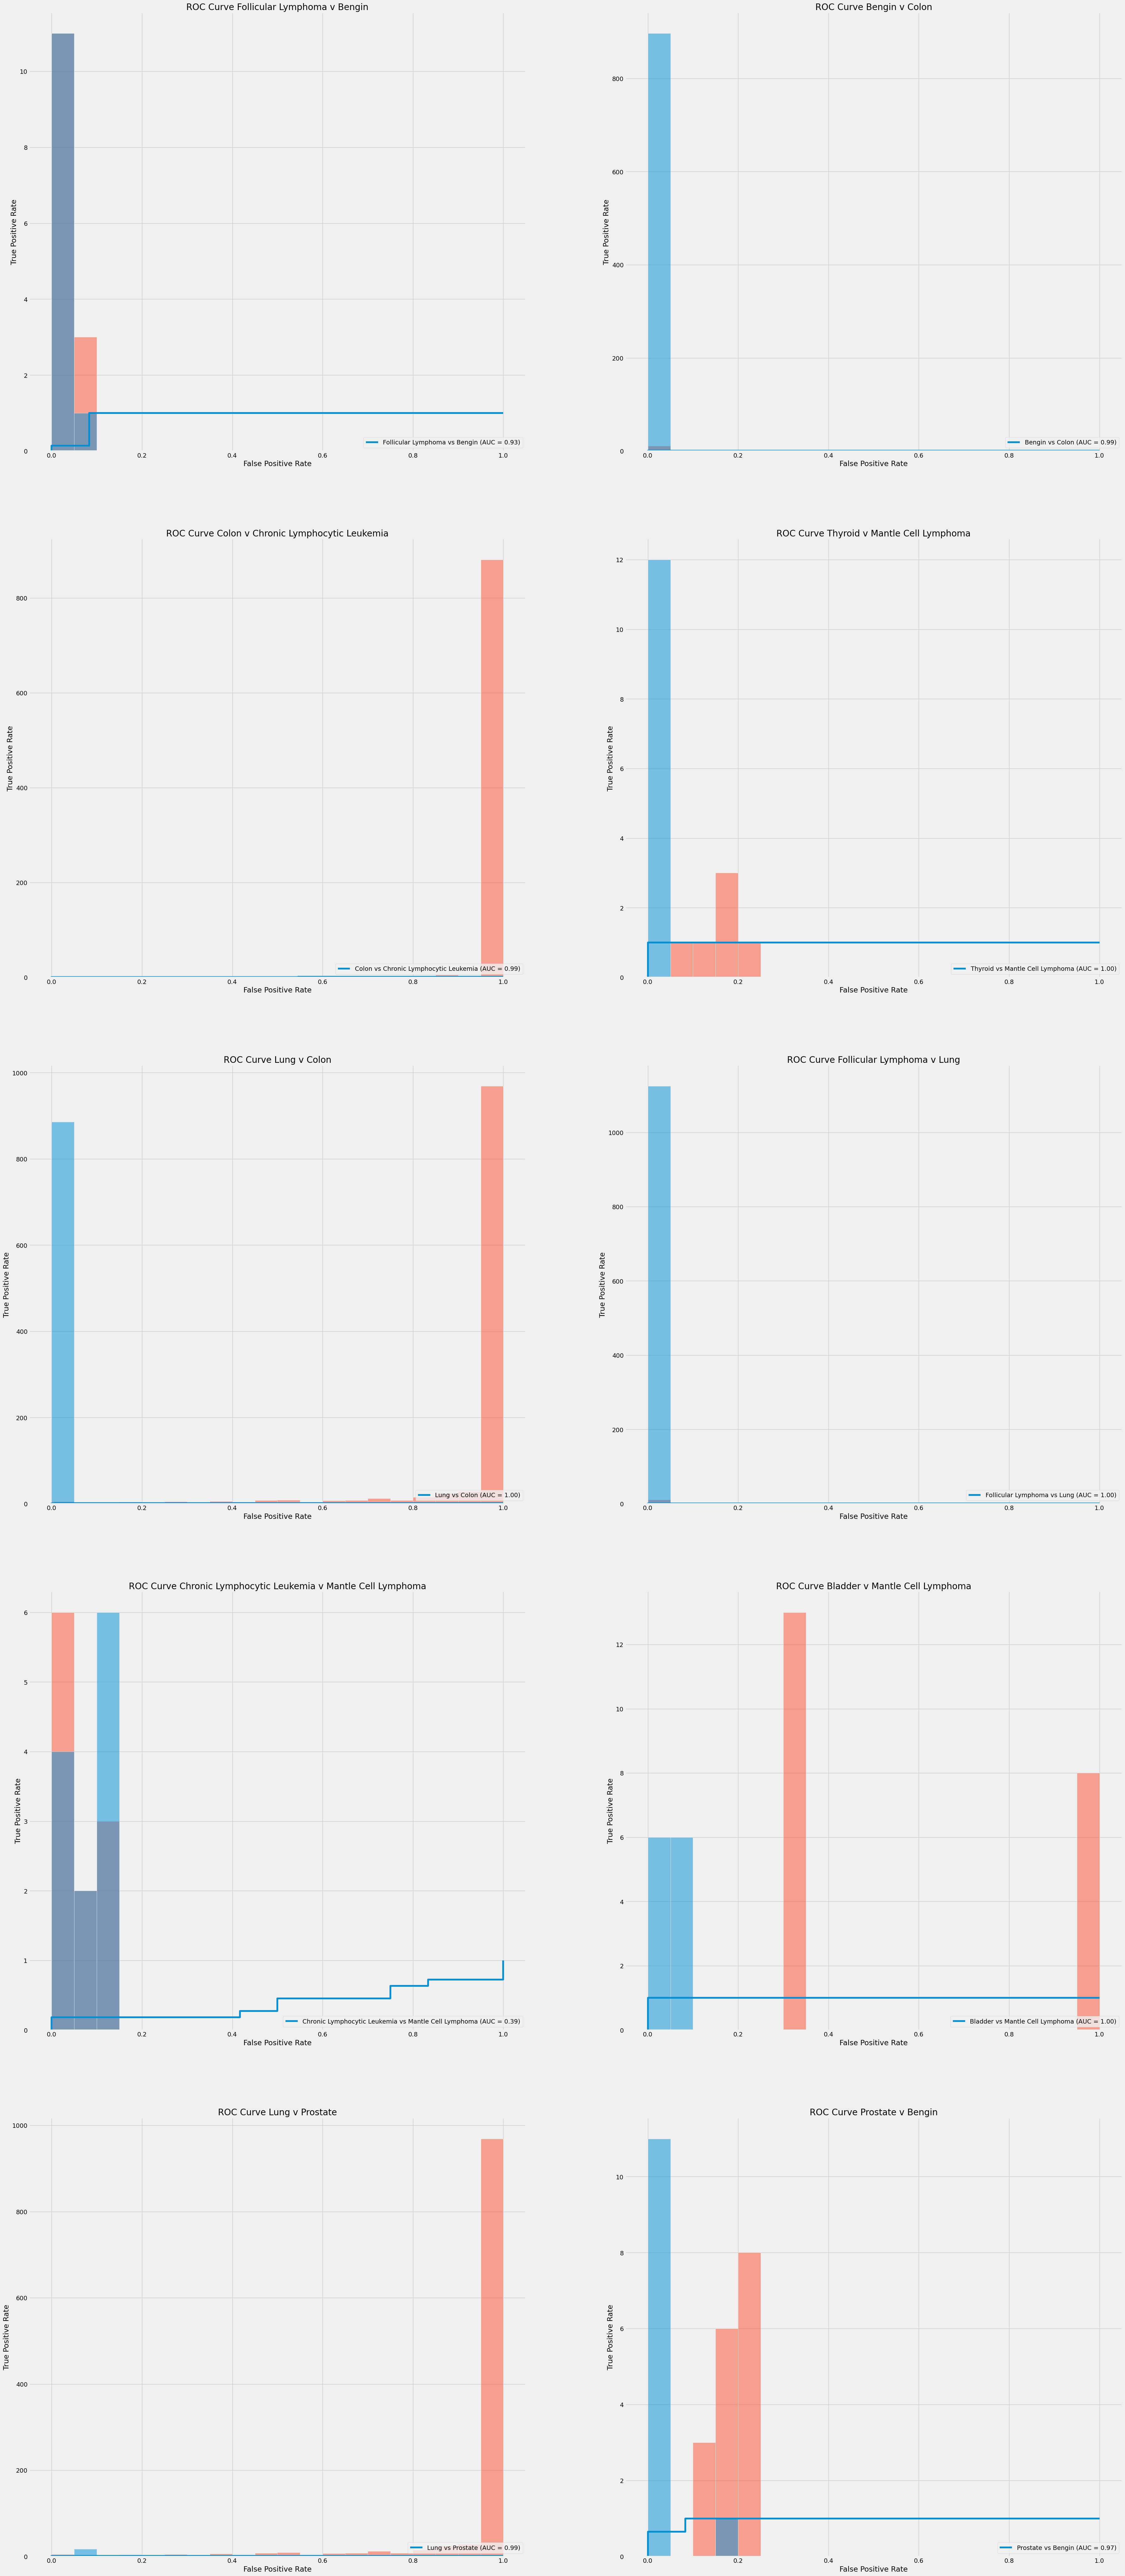

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

# Plots the Probability Distributions and the ROC Curves One vs One

plt.figure(figsize=(40, 100))
bins = [i / 20 for i in range(20)] + [1]
roc_auc_ovo = {}

def get_all_roc_coordinates(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities, pos_label=1)
    return tpr, fpr

for i in range(10):
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = train_gen.class_indices[c1]
    title = f"{c1} vs {c2}"

    # Prepares an auxiliary dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = true_labels
    df_aux['prob'] = predictions[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == train_gen.class_indices[c1]) | (df_aux['class'] == train_gen.class_indices[c2])]
    df_aux['class'] = [1 if y == train_gen.class_indices[c1] else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # Check if both classes are present
    if len(set(df_aux['class'])) == 2:
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(5, 2, i+1)
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)
        ax.set_title(title)
        ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
        ax.set_xlabel(f"P(x = {c1})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(5, 2, i+1)  # Use the same index for ROC curve
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        roc_auc = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Create RocCurveDisplay
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=title)

        # Plot ROC curve
        roc_display.plot(ax=ax_bottom)
        ax_bottom.set_title(f"ROC Curve {c1} v {c2}")

        # Store ROC AUC OvO
        roc_auc_ovo[title] = roc_auc

plt.savefig('ROC_googlenet.png')
plt.show()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

Follicular Lymphoma vs Bengin ROC AUC OvO: 0.9286
Bengin vs Colon ROC AUC OvO: 0.9901
Colon vs Chronic Lymphocytic Leukemia ROC AUC OvO: 0.9912
Thyroid vs Mantle Cell Lymphoma ROC AUC OvO: 1.0000
Lung vs Colon ROC AUC OvO: 0.9996
Follicular Lymphoma vs Lung ROC AUC OvO: 0.9994
Chronic Lymphocytic Leukemia vs Mantle Cell Lymphoma ROC AUC OvO: 0.3864
Bladder vs Mantle Cell Lymphoma ROC AUC OvO: 1.0000
Lung vs Prostate ROC AUC OvO: 0.9929
Prostate vs Bengin ROC AUC OvO: 0.9706
average ROC AUC OvO: 0.9259


In [ ]:
# DenseNet
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers+369582):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, (3, 3), padding='same')(x)
        x = Concatenate()([x, x])
    return x

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

x = Conv2D(64, (7, 7), padding='same', activation='relu', strides=(2, 2))(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

num_blocks = 3
growth_rate = 32

for _ in range(num_blocks):
    x = dense_block(x, 6, growth_rate)
    num_channels = int(x.shape[-1])
    x = Conv2D(num_channels // 2, (1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output_layer = Dense(len(train_gen.class_indices), activation='softmax')(x)

densenet_model = Model(inputs=input_layer, outputs=output_layer)
densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
batch_size = 64

total_train_batches = train_gen.samples//batch_size
total_val_batches = valid_gen.samples//batch_size

In [ ]:
epochs = 10

history = densenet_model.fit(
    x = train_gen ,
    epochs= epochs ,
    validation_data= valid_gen,
    steps_per_epoch=total_train_batches//10,
    validation_steps=total_val_batches//10,
    shuffle = False,
    verbose= 1
)

In [ ]:
# Define needed variables
tr_acc = [acc * 100 for acc in history.history['accuracy']]
tr_loss = history.history['loss']
val_acc = [acc * 100 for acc in history.history['val_accuracy']]
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
test_steps = len(test_gen)
predictions = densenet_model.predict(test_gen, steps=test_steps)

# Get true labels from the test data generator (assuming it's a generator with labels)
true_labels = test_gen.classes

# Calculate accuracy
accuracy = np.mean(np.argmax(predictions, axis=1) == true_labels) * 100

# Accuracy values
train_accuracy = 97.06
validation_accuracy = 95
test_accuracy = accuracy

labels = ['Training', 'Validation', 'Testing']

accuracy_values = [train_accuracy, validation_accuracy, test_accuracy]

# Bar positions
x = range(len(labels))

plt.bar(x, accuracy_values, color=['blue', 'green', 'red'])

plt.title('Model Accuracy')
plt.xlabel('Data Split')
plt.ylabel('Accuracy')

for i, value in enumerate(accuracy_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.xticks(x, labels)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, r2_score

# Precision, Recall, F1 Score
precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
r2 = r2_score(true_labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("R2 Score:", r2)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

# Plots the Probability Distributions and the ROC Curves One vs One

plt.figure(figsize=(40, 100))
bins = [i / 20 for i in range(20)] + [1]
roc_auc_ovo = {}

def get_all_roc_coordinates(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities, pos_label=1)
    return tpr, fpr

for i in range(10):
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = train_gen.class_indices[c1]
    title = f"{c1} vs {c2}"

    # Prepares an auxiliary dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = true_labels
    df_aux['prob'] = predictions[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == train_gen.class_indices[c1]) | (df_aux['class'] == train_gen.class_indices[c2])]
    df_aux['class'] = [1 if y == train_gen.class_indices[c1] else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # Check if both classes are present
    if len(set(df_aux['class'])) == 2:
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(5, 2, i+1)
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)
        ax.set_title(title)
        ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
        ax.set_xlabel(f"P(x = {c1})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(5, 2, i+1)  # Use the same index for ROC curve
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        roc_auc = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Create RocCurveDisplay
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=title)

        # Plot ROC curve
        roc_display.plot(ax=ax_bottom)
        ax_bottom.set_title(f"ROC Curve {c1} v {c2}")

        # Store ROC AUC OvO
        roc_auc_ovo[title] = roc_auc

plt.savefig('ROC_densenet.png')
plt.show()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")